# Process raw cell size data from BacDive

### Preparation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

### Data table

The input data were retrieved from BacDive.

- Some records do not have IDs or other columns but size.

In [3]:
df = pd.read_csv('New_Data.csv')
df.head()

,ID,designation_header,strain_number_header,is_type_strain_header,species,Cell length (µm),Cell Width (µm),Cell Shape,Reference,NCBI ID
0,159837.0,OUC007,"KCTC 52933, MCCC 1K03450, OUC007",1.0,Abyssibacter profundi,1.7-1.9,0.4-0.6,rod-shaped,66716.0,2182787.0
1,132478.0,L81,"DSM 29592, JCM 30920",1.0,Abyssivirga alkaniphila,2.0-5.0,0.5,rod-shaped,43989.0,1675854.0
2,24718.0,FYK2218,"DSM 28897, KCTC 12899, NBRC 101209",1.0,Acanthopleuribacter pedis,2.4-4.7,0.7-1,rod-shaped,32501.0,442870.0
3,7517.0,CSC,"DSM 14247, CCUG 49701, NBRC 107788, CIP 109141",1.0,Acaricomes phytoseiuli,1-1.5,0.5-0.8,coccus-shaped,31628.0,291968.0
4,134101.0,Z7,"JCM 12359, AS1.5012",1.0,Acetanaerobacterium elongatum,6,0.3,rod-shaped,31285.0,258515.0


In [4]:
df.shape[0]

5284

Drop records without ID.

In [5]:
df = df.dropna(subset=['ID']).astype({'ID': int})
df.shape

(5216, 10)

Drop records without reference.

In [6]:
df = df.dropna(subset=['Reference']).astype({'Reference': int})
df.shape

(5018, 10)

Fix two typos.

In [7]:
df[df['Cell Width (µm)'] == '0.3.0.6']

,ID,designation_header,strain_number_header,is_type_strain_header,species,Cell length (µm),Cell Width (µm),Cell Shape,Reference,NCBI ID
3714,158646,1-32,"KCTC 52859, CCTCC AB 2017084",1.0,Pedobacter mongoliensis,1-2,0.3.0.6,rod-shaped,65371,NaN


In [8]:
df.at[3714, 'Cell Width (µm)'] = '0.3-0.6'

In [9]:
df[df['Cell Width (µm)'] == '2.0-4-0']

,ID,designation_header,strain_number_header,is_type_strain_header,species,Cell length (µm),Cell Width (µm),Cell Shape,Reference,NCBI ID
2221,1511,YKJ-13,"DSM 18867, CIP 107405, JCM 10872, KCCM 80002",1.0,Jeotgalibacillus alimentarius,1.0-1.2,2.0-4-0,rod-shaped,23065,135826.0


In [10]:
df.at[2221, 'Cell Width (µm)'] = '2.0-4.0'

NCBI TaxID

In [11]:
df['TaxID'] = df['NCBI ID'].apply(lambda x: x if np.isnan(x) else str(int(x)))

Drop records without NCBI TaxID.

In [12]:
df.drop(columns=['NCBI ID'], inplace=True)

### Cell size data

Check missing data.

In [13]:
df.shape[0]

5018

In [14]:
df['Cell length (µm)'].dropna().shape[0]

5018

In [15]:
df['Cell Width (µm)'].dropna().shape[0]

4797

For records without width:

In [16]:
df_ = df[df['Cell Width (µm)'].isna()]
df_.shape[0]

221

In [17]:
df_['Cell Shape'].value_counts()

coccus-shaped         103
rod-shaped             89
sphere-shaped           8
star-shaped             2
pleomorphic-shaped      2
ovoid-shaped            2
spiral-shaped           1
oval-shaped             1
filament-shaped         1
Name: Cell Shape, dtype: int64

For coccus- or shpere-shaped cells, let width = length.

In [18]:
lengths = df[df['Cell Width (µm)'].isna() & df['Cell Shape'].isin([
    'coccus-shaped', 'sphere-shaped'])]['Cell length (µm)']

In [19]:
for idx, val in lengths.iteritems():
    df.at[idx, 'Cell Width (µm)'] = val

Drop records of other cell shapes.

In [20]:
df.dropna(subset=['Cell Width (µm)'], inplace=True)
df.shape[0]

4908

Standardize the format of lenth and width values.

- For ranges (e.g., `0.2-0.5`), take geometric mean.
- For minimum / maximum values, take boundary.
- There are some exceptions. The following code deals with exceptions.

In [21]:
def size_to_num(size):
    """Convert a size string into a number.
    """
    if size.endswith(' µ'):
        size = size[:-2]
    if size.endswith(' mm'):
        size = size[:-3]
    if '-' in size:
        return np.sqrt(np.prod([float(x) for x in size.split('-')]))
    elif size.startswith(('>', '<')):
        return float(size[1:])
    else:
        return float(size)

In [22]:
df['length'] = df['Cell length (µm)'].apply(size_to_num)

In [23]:
df['width'] = df['Cell Width (µm)'].apply(size_to_num)

Ensure that length is greater than or equal to width.

In [24]:
df[['length', 'width']] = df[['length', 'width']].apply(
    lambda x: pd.Series([max(x), min(x)]), axis=1)

### Data distribution

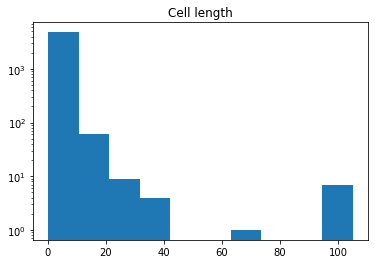

In [25]:
plt.hist(df['length'], log=True)
plt.title('Cell length');

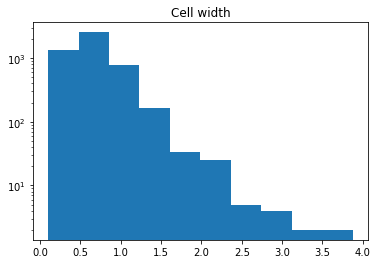

In [26]:
plt.hist(df['width'], log=True)
plt.title('Cell width');

In [27]:
df.drop(columns=['Cell length (µm)', 'Cell Width (µm)'], inplace=True)

### Organization

In [28]:
df.set_index('ID', inplace=True)

In [29]:
df.columns = ['designation', 'strain', 'type_strain', 'species', 'shape', 'reference', 'taxid', 'length', 'width']

In [30]:
df['type_strain'] = df['type_strain'].astype(int)

### Cell shape

In [31]:
df['shape'].value_counts()

rod-shaped            4193
coccus-shaped          296
ovoid-shaped           168
spiral-shaped           40
vibrio-shaped           21
filament-shaped         18
pleomorphic-shaped      17
oval-shaped             11
sphere-shaped           10
helical-shaped           9
curved-shaped            5
other                    3
ellipsoidal              2
crescent-shaped          1
ring-shaped              1
Name: shape, dtype: int64

In [32]:
df.query('shape == "rod-shaped"').shape[0] / df.shape[0]

0.854319478402608

In [33]:
df.query('shape == "coccus-shaped"').shape[0] / df.shape[0]

0.06030969845150774

In [34]:
df.query('shape == "ovoid-shaped"').shape[0] / df.shape[0]

0.034229828850855744

Rod-shaped and coccus-shaped cells (together making 91.23% of all data) can be simplified as capsules.

### Cell volume and surface area

First, assume that cell height equals to cell width. Therefore we have:

Second, assume that cells are [capsules](https://en.wikipedia.org/wiki/Capsule_(geometry)).

- Volume: $ V = \pi r^{2} (\frac{4}{3} r + a)$

- Surface area: $ S = 2 \pi r (2r + a) $

In which $a$ = length - width, $r$ = width / 2.

In [35]:
df['volume'] = np.pi * (df['width'] / 2) ** 2 * ((4 / 3) * (df['width'] / 2) + (df['length'] - df['width']))

In [36]:
df['surface'] = 2 * np.pi * (df['width'] / 2) * (2 * (df['width'] / 2) + (df['length'] - df['width']))

Alternatively, one may assume that cells are [ellipsoids](https://en.wikipedia.org/wiki/Ellipsoid):

- Volume: $ V = \frac{4}{3} \pi a b c$
- Surface area (approximation): $ S \approx 4 \pi \sqrt[p]{\frac{a^{p}b^{p} + a^{p}c^{p} + b^{p}c^{p}}{3}} $

In which a, b, c are the radia of the three dimensions (i.e., half of length, width and height), $ p \approx $  1.6075.

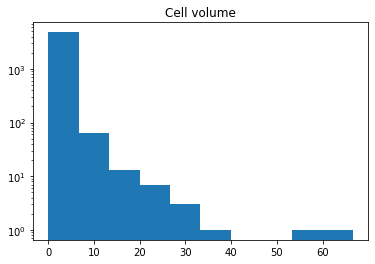

In [37]:
plt.hist(df['volume'], log=True)
plt.title('Cell volume');

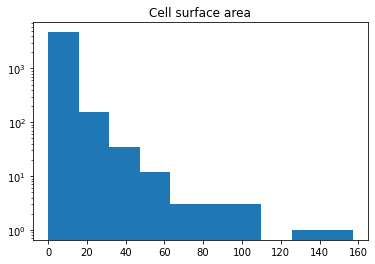

In [38]:
plt.hist(df['surface'], log=True)
plt.title('Cell surface area');

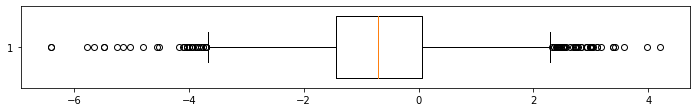

In [39]:
plt.figure(figsize=(12, 1.5))
plt.boxplot(df['volume'].apply(np.log), widths=0.75, vert=False);

### Output

In [40]:
df.shape[0]

4908

In [41]:
df.to_csv('data.tsv', sep='\t')